In [1]:
%pylab inline
from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm
from helpers.dataTransfer import saveFullDataToRemote
from qick.qick_asm import fs_dac

Populating the interactive namespace from numpy and matplotlib


ImportError: cannot import name 'fs_dac'

# Data Saving Info

In [ ]:
remotePath = "C:/Users/hatla/Downloads"
sampleName = "Q1"

# Configuring the channels

The data in this notebook was taken with a wiring diagram similar to the above. The QICK has eight RF DACs which can be configured in multiple ways. Using the QICK, two RF DACs are needed to control the qubit and its readout resonator, respectively. Also, the qubit control pulses (< 6 GHz) were directly synthesized without the use of an analog mixer. Note that the QICK RF board was not used for these measurements, only the ZCU111 evaluation board plus the analog components specified in the diagram.

In [ ]:
# Load bitstream with custom overlay
soc = QickSoc()
soc.set_nyquist(ch=6,nqz=1) #Readout_I
soc.set_nyquist(ch=7,nqz=1) #Readout_Q

hw_cfg={"res_ch_I":3,
        "res_ch_Q":7
       }

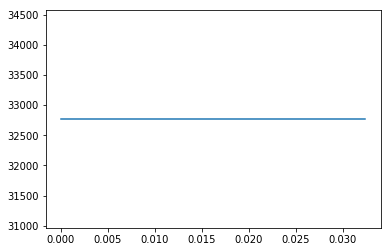

In [48]:
def constWithOffset(amp, length, freq, offset):
    tList = np.arange(length)
    a0_I = offset * np.cos(np.pi * 2 * freq * tList * soc.cycles2us(1)/16)
    a0_Q = offset * np.sin(np.pi * 2 * freq * tList * soc.cycles2us(1)/16)
    return  amp * np.ones_like(tList) + a0_I, a0_Q

def cosWithOffset(amp, length, freq, offset, phase=0):
    tList = np.arange(length)
    a_I = amp * np.cos(np.pi * 2 * freq * tList * soc.cycles2us(1)/16 + phase/180*np.pi) + offset
    a_Q = np.zeros_like(a_I)
    return  a_I, a_Q


plt.figure()
t_list = np.arange(200) * soc.cycles2us(1)/16
plt.plot(t_list, cosWithOffset(0, 200, 10,32767)[0])

In [60]:
class CWProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        cfg["adc_lengths"]=[cfg["readout_length"]]*2          #add length of adc acquisition to config
        cfg["adc_freqs"]=[soc.adcfreq(cfg["frequency"])]*2   #add frequency of adc dds to config
        self.gain_I = int(cfg["pulse_gain"])
        self.gain_Q = int(cfg["pulse_gain"] * cfg["IQScale"])
        self.phase_I = deg2reg(0)
        self.phase_Q = deg2reg(cfg["skewPhase"])
        self.pulse_length = cfg["pulse_length"]
        self.freq = cfg["frequency"]
        
#         self.add_pulse(ch=cfg["res_ch_I"], name="measure", style="const", length=cfg["pulse_length"])  #add a constant pulse to the pulse library
#         self.add_pulse(ch=cfg["res_ch_Q"], name="measure", style="const", length=cfg["pulse_length"])  #add a constant pulse to the pulse library
# 
#         iData0, qData0 = constWithOffset(self.gain_I, self.pulse_length, self.freq, cfg["offSet_I"])
#         iData1, qData1 = constWithOffset(self.gain_Q, self.pulse_length, self.freq, cfg["offSet_Q"])
# 
        iData0, qData0 = cosWithOffset(self.gain_I, self.pulse_length, self.freq, cfg["offSet_I"], 0)
        iData1, qData1 = cosWithOffset(self.gain_Q, self.pulse_length, self.freq, cfg["offSet_Q"], cfg["skewPhase"])
    
        self.add_pulse(ch=cfg["res_ch_I"], name="measure", style="arb", idata= iData0, qdata= qData0 ) #add a constant pulse to the pulse library
        self.add_pulse(ch=cfg["res_ch_Q"], name="measure", style="arb", idata= iData1, qdata= qData1 ) #add a constant pulse to the pulse library
        
        
        self.freq=soc.freq2reg(soc.adcfreq(cfg["frequency"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.synci(200)  # give processor some time to configure pulses
        

        
    
    def body(self):
        cfg=self.cfg   
        self.trigger_adc(adc1=1, adc2=0,adc_trig_offset=cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=cfg["res_ch_I"], name="measure", freq=self.freq, phase=self.phase_I, gain=32767, mode=0, outsel=1, t=0, play=True)
#         self.pulse(ch=cfg["res_ch_Q"], name="measure", freq=self.freq, phase=self.phase_Q, gain=self.gain_Q, mode=0, outsel=2, t=0, play=True) 
        self.marker(t=100, t1=0, short=False)
#         self.marker(t=200, t1=0, short=False)
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels

expt_config={
        "reps":2, # --Fixed
        "pulse_length": int(fs_dac/50*25), # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "adc_trig_offset": 0, # [Clock ticks]
        "soft_avgs":1,
        "relax_delay": 0,
    
        "frequency": 0, # [MHz]
        "pulse_gain":0, # [DAC units]
        "offSet_I": 20000, # [DAC units]
        "offSet_Q": 0, # [DAC units]
        "skewPhase":-83, # [Degrees]
        "IQScale":0.95
       }

config={**hw_cfg,**expt_config}
prog =CWProgram(config)
adc1, adc2 = prog.acquire(soc, load_pulses=True, progress=True)

